In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GenAIproject/parsed_legal_qa_trainenglish.csv")

# Split into 80% train and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

In [ ]:
# For training set
print("Train Label Counts:")
print(train_df['label'].value_counts())

# For validation set
print("\nValidation Label Counts:")
print(val_df['label'].value_counts())


Train Label Counts:
label
Y    490
N    470
Name: count, dtype: int64

Validation Label Counts:
label
Y    122
N    118
Name: count, dtype: int64


In [ ]:
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import pickle
import os
from transformers import BertTokenizer

class MNLIDataBert(Dataset):

  def __init__(self, train_df, val_df):
    self.label_dict = {'Y': 0, 'N': 1}

    self.train_df = train_df
    self.val_df = val_df

    self.base_path = '/content/'
    self.tokenizer = BertTokenizer.from_pretrained('nlpaueb/legal-bert-small-uncased', do_lower_case=True) # Using a pre-trained BERT tokenizer to encode sentences
    self.train_data = None
    self.val_data = None
    self.init_data()

  def init_data(self):
    self.train_data = self.load_data(self.train_df)
    self.val_data = self.load_data(self.val_df)

  def load_data(self, df):
    MAX_LEN = 512
    token_ids = []
    mask_ids = []
    seg_ids = []
    y = []

    premise_list = df['query'].to_list()
    hypothesis_list = df['article'].to_list()
    label_list = df['label'].to_list()

    for (premise, hypothesis, label) in zip(premise_list, hypothesis_list, label_list):
      premise_id = self.tokenizer.encode(premise, add_special_tokens = False,truncation=True, max_length=512)
      hypothesis_id = self.tokenizer.encode(hypothesis, add_special_tokens = False, truncation=True, max_length=512)
      pair_token_ids = [self.tokenizer.cls_token_id] + premise_id + [self.tokenizer.sep_token_id] + hypothesis_id + [self.tokenizer.sep_token_id]

      # Check length
      #print(f"Token length after truncation: {len(pair_token_ids)}")
      premise_len = len(premise_id)
      hypothesis_len = len(hypothesis_id)

      segment_ids = torch.tensor([0] * (premise_len + 2) + [1] * (hypothesis_len + 1))  # sentence 0 and sentence 1
      attention_mask_ids = torch.tensor([1] * (premise_len + hypothesis_len + 3))  # mask padded values

      # Ensure that the total length doesn't exceed 512 tokens
      if len(pair_token_ids) > 512:
        pair_token_ids = pair_token_ids[:512]
        segment_ids = segment_ids[:512]
        attention_mask_ids = attention_mask_ids[:512]

      token_ids.append(torch.tensor(pair_token_ids))
      seg_ids.append(segment_ids)
      mask_ids.append(attention_mask_ids)
      y.append(self.label_dict[label])

    token_ids = pad_sequence(token_ids, batch_first=True)
    mask_ids = pad_sequence(mask_ids, batch_first=True)
    seg_ids = pad_sequence(seg_ids, batch_first=True)
    y = torch.tensor(y)
    dataset = TensorDataset(token_ids, mask_ids, seg_ids, y)
    print(len(dataset))
    return dataset

  def get_data_loaders(self, batch_size=32, shuffle=True):
    train_loader = DataLoader(
      self.train_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    val_loader = DataLoader(
      self.val_data,
      shuffle=shuffle,
      batch_size=batch_size
    )

    return train_loader, val_loader

mnli_dataset = MNLIDataBert(train_df, val_df)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

960
240


In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased", num_labels=2)
optimizer = AdamW(model.parameters(), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
mnli_dataset = MNLIDataBert(train_df, val_df)
train_loader, val_loader = mnli_dataset.get_data_loaders(batch_size=4)


960
240


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch
import time

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

EPOCHS = 5
CHECKPOINT_PATH = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint.pt'

def train(model, train_loader, val_loader, optimizer, resume=False):
    start_epoch = 0

    # Resume training if checkpoint is provided
    if resume:
        print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resumed from epoch {start_epoch}")

    for epoch in range(start_epoch, EPOCHS):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, CHECKPOINT_PATH)
        print(f"Checkpoint saved for epoch {epoch+1}\n")


In [ ]:
# First time training
train(model, train_loader, val_loader, optimizer, resume=False)

#

Epoch 1: train_loss: 0.7064 train_acc: 0.5052 | val_loss: 0.6853 val_acc: 0.5458
00:39:19.75


RuntimeError: Parent directory /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal does not exist.

In [ ]:
# Ensure directory exists before saving
os.makedirs(os.path.dirname(CHECKPOINT_PATH), exist_ok=True)

# Save checkpoint
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, CHECKPOINT_PATH)
print(f"Checkpoint saved for epoch {1}\n")


Checkpoint saved for epoch 1



In [ ]:
import torch
import time

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

CHECKPOINT_PATH = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint.pt'

def train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5):


    # Resume training if checkpoint is provided
    if resume:
        print(f"Loading checkpoint from {CHECKPOINT_PATH}...")
        checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")

    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, CHECKPOINT_PATH)
        print(f"Checkpoint saved for epoch {epoch+1}\n")


In [ ]:
train(model, train_loader, val_loader, optimizer, resume=True, start_epoch=1, total_epochs=5)


Loading checkpoint from /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint.pt...
Checkpoint loaded. Resuming from epoch 2.
Epoch 2: train_loss: 0.6932 train_acc: 0.5406 | val_loss: 0.6918 val_acc: 0.5500
00:39:49.41
Checkpoint saved for epoch 2

Epoch 3: train_loss: 0.6624 train_acc: 0.5833 | val_loss: 0.7019 val_acc: 0.5208
00:40:07.15
Checkpoint saved for epoch 3

Epoch 4: train_loss: 0.6093 train_acc: 0.6656 | val_loss: 0.6754 val_acc: 0.6208
00:40:05.49
Checkpoint saved for epoch 4

Epoch 5: train_loss: 0.5107 train_acc: 0.7479 | val_loss: 0.7252 val_acc: 0.5417
00:40:12.13
Checkpoint saved for epoch 5



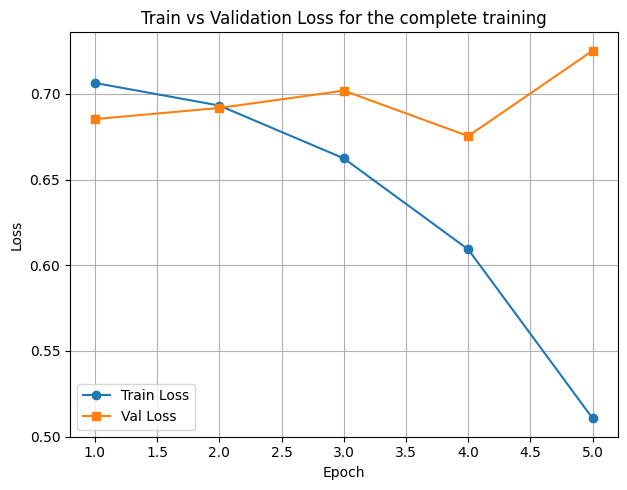

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = [1, 2, 3, 4, 5]
train_loss = [0.7064, 0.6932, 0.6624, 0.6093, 0.5107]
val_loss =   [0.6853, 0.6918, 0.7019, 0.6754, 0.7252]


# Plotting
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss for the complete training')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


# **Freezing the bottom 5 layers**

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

# Load 6-layer LegalBERT
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased", num_labels=2)

# Freeze bottom 4 encoder layers: layers 0, 1, 2, 3,4
for layer_idx in range(5):
    for param in model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

# Create optimizer with only trainable parameters (top 2 layers + classifier)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch
import time
import os

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal'

def train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Resume training if requested
    if resume:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch5_{start_epoch}.pt')
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")
        else:
            print(f"Checkpoint {checkpoint_path} not found. Starting fresh.")

    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint for this epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch5_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {epoch+1} at {checkpoint_path}\n")


In [ ]:
# Example: resume from epoch 3
train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=10)


Epoch 1: train_loss: 0.7004 train_acc: 0.5062 | val_loss: 0.6921 val_acc: 0.5458
00:00:21.75
Checkpoint saved for epoch 1 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch5_1.pt

Epoch 2: train_loss: 0.6900 train_acc: 0.5406 | val_loss: 0.6933 val_acc: 0.5750
00:00:21.32
Checkpoint saved for epoch 2 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch5_2.pt

Epoch 3: train_loss: 0.6697 train_acc: 0.5833 | val_loss: 0.6847 val_acc: 0.5375
00:00:22.20
Checkpoint saved for epoch 3 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch5_3.pt

Epoch 4: train_loss: 0.6486 train_acc: 0.6260 | val_loss: 0.7318 val_acc: 0.5500
00:00:21.81
Checkpoint saved for epoch 4 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch5_4.pt

Epoch 5: train_loss: 0.6275 train_acc: 0.6438 | val_loss: 0.7615 val_acc: 0.5417
00:00:22.00
Checkpoint saved for epoch 5 at /content/drive/MyDr

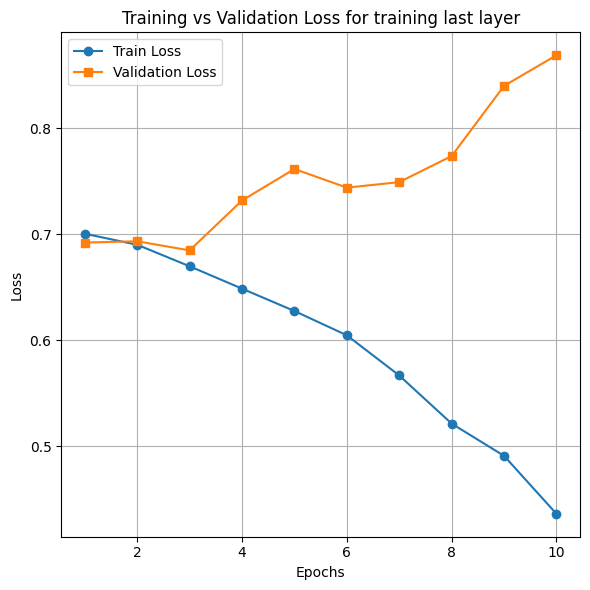

In [ ]:
import matplotlib.pyplot as plt

# Your logged metrics
epochs = list(range(1, 11))
train_loss = [0.7004, 0.6900, 0.6697, 0.6486, 0.6275, 0.6046, 0.5667, 0.5213, 0.4909, 0.4362]
val_loss   = [0.6921, 0.6933, 0.6847, 0.7318, 0.7615, 0.7439, 0.7491, 0.7737, 0.8399, 0.8688]

# Plotting
plt.figure(figsize=(6, 6))
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for training last layer')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# **Freezing the bottom 4 layers**

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

# Load 6-layer LegalBERT
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased", num_labels=2)

# Freeze bottom 4 encoder layers: layers 0, 1, 2, 3
for layer_idx in range(4):
    for param in model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

# Create optimizer with only trainable parameters (top 2 layers + classifier)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)


pytorch_model.bin:   0%|          | 0.00/141M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable: {name}")
    else:
        print(f"Frozen:    {name}")


Trainable: bert.embeddings.word_embeddings.weight
Trainable: bert.embeddings.position_embeddings.weight
Trainable: bert.embeddings.token_type_embeddings.weight
Trainable: bert.embeddings.LayerNorm.weight
Trainable: bert.embeddings.LayerNorm.bias
Frozen:    bert.encoder.layer.0.attention.self.query.weight
Frozen:    bert.encoder.layer.0.attention.self.query.bias
Frozen:    bert.encoder.layer.0.attention.self.key.weight
Frozen:    bert.encoder.layer.0.attention.self.key.bias
Frozen:    bert.encoder.layer.0.attention.self.value.weight
Frozen:    bert.encoder.layer.0.attention.self.value.bias
Frozen:    bert.encoder.layer.0.attention.output.dense.weight
Frozen:    bert.encoder.layer.0.attention.output.dense.bias
Frozen:    bert.encoder.layer.0.attention.output.LayerNorm.weight
Frozen:    bert.encoder.layer.0.attention.output.LayerNorm.bias
Frozen:    bert.encoder.layer.0.intermediate.dense.weight
Frozen:    bert.encoder.layer.0.intermediate.dense.bias
Frozen:    bert.encoder.layer.0.output

In [ ]:
import torch
import time
import os

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal'

def train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Resume training if requested
    if resume:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{start_epoch}.pt')
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")
        else:
            print(f"Checkpoint {checkpoint_path} not found. Starting fresh.")

    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint for this epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {epoch+1} at {checkpoint_path}\n")


In [ ]:
# Example: resume from epoch 3
train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5)


Epoch 1: train_loss: 0.7037 train_acc: 0.5052 | val_loss: 0.6899 val_acc: 0.5375
00:34:44.98
Checkpoint saved for epoch 1 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_1.pt

Epoch 2: train_loss: 0.6921 train_acc: 0.5490 | val_loss: 0.6865 val_acc: 0.5208
00:34:21.00
Checkpoint saved for epoch 2 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_2.pt

Epoch 3: train_loss: 0.6832 train_acc: 0.5583 | val_loss: 0.6807 val_acc: 0.5417
00:34:37.87
Checkpoint saved for epoch 3 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_3.pt



In [ ]:
# Example: resume from epoch 3
train(model, train_loader, val_loader, optimizer, resume=True, start_epoch=3, total_epochs=5)


Loading checkpoint from /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_3.pt...
Checkpoint loaded. Resuming from epoch 4.
Epoch 4: train_loss: 0.6493 train_acc: 0.6229 | val_loss: 0.6821 val_acc: 0.5500
00:00:23.87
Checkpoint saved for epoch 4 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_4.pt

Epoch 5: train_loss: 0.6214 train_acc: 0.6729 | val_loss: 0.6992 val_acc: 0.5583
00:00:24.17
Checkpoint saved for epoch 5 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_5.pt



In [ ]:
# Example: resume from epoch 3
train(model, train_loader, val_loader, optimizer, resume=True, start_epoch=5, total_epochs=10)


Loading checkpoint from /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_5.pt...
Checkpoint loaded. Resuming from epoch 6.
Epoch 6: train_loss: 0.5428 train_acc: 0.7229 | val_loss: 0.7541 val_acc: 0.5792
00:00:23.14
Checkpoint saved for epoch 6 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_6.pt

Epoch 7: train_loss: 0.4846 train_acc: 0.7646 | val_loss: 0.8241 val_acc: 0.5542
00:00:23.29
Checkpoint saved for epoch 7 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_7.pt

Epoch 8: train_loss: 0.4270 train_acc: 0.7990 | val_loss: 0.9407 val_acc: 0.5583
00:00:23.26
Checkpoint saved for epoch 8 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch_8.pt

Epoch 9: train_loss: 0.3247 train_acc: 0.8583 | val_loss: 1.0408 val_acc: 0.5583
00:00:23.49
Checkpoint saved for epoch 9 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoc

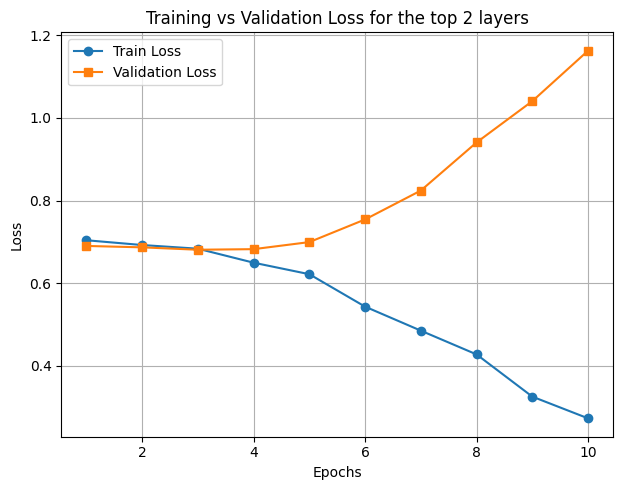

In [ ]:
import matplotlib.pyplot as plt

# Data
epochs = list(range(1, 11))
train_loss = [0.7037, 0.6921, 0.6832, 0.6493, 0.6214, 0.5428, 0.4846, 0.4270, 0.3247, 0.2721]
val_loss   = [0.6899, 0.6865, 0.6807, 0.6821, 0.6992, 0.7541, 0.8241, 0.9407, 1.0408, 1.1630]

# Plot Loss
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Train Loss')
plt.plot(epochs, val_loss, marker='s', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss for the top 2 layers')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


# **Freezing the bottom 3 layers**

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

# Load 6-layer LegalBERT
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased", num_labels=2)
=
# Freeze bottom 3 encoder layers: layers 0, 1, 2,
for layer_idx in range(3):
    for param in model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

# Create optimizer with only trainable parameters (top 2 layers + classifier)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-5)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch
import time
import os

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal'

def train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Resume training if requested
    if resume:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch3_{start_epoch}.pt')
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")
        else:
            print(f"Checkpoint {checkpoint_path} not found. Starting fresh.")

    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint for this epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch3_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {epoch+1} at {checkpoint_path}\n")


In [ ]:
# Example: resume from epoch 3
train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=10)


Epoch 1: train_loss: 0.7073 train_acc: 0.5062 | val_loss: 0.6805 val_acc: 0.5458
00:00:23.03
Checkpoint saved for epoch 1 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_1.pt

Epoch 2: train_loss: 0.6863 train_acc: 0.5281 | val_loss: 0.7225 val_acc: 0.5000
00:00:23.24
Checkpoint saved for epoch 2 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_2.pt

Epoch 3: train_loss: 0.6680 train_acc: 0.5875 | val_loss: 0.6718 val_acc: 0.5667
00:00:23.55
Checkpoint saved for epoch 3 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_3.pt

Epoch 4: train_loss: 0.6339 train_acc: 0.6469 | val_loss: 0.6671 val_acc: 0.5750
00:00:23.72
Checkpoint saved for epoch 4 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_4.pt

Epoch 5: train_loss: 0.5564 train_acc: 0.7292 | val_loss: 0.7647 val_acc: 0.5583
00:00:23.95
Checkpoint saved for epoch 5 at /content/drive/MyDr

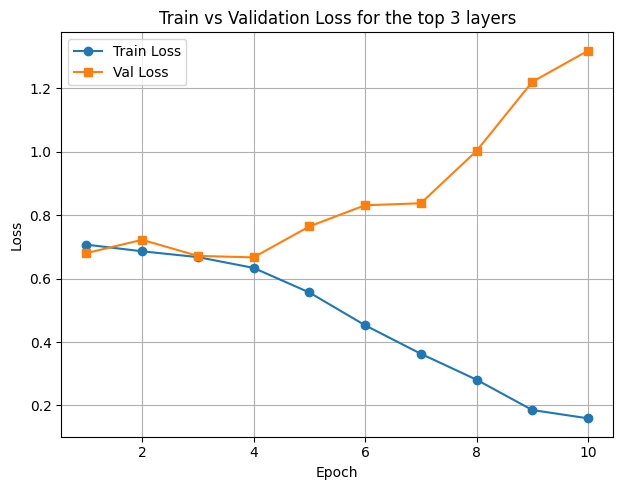

In [ ]:
import matplotlib.pyplot as plt

# Epoch data
epochs = list(range(1, 11))
train_loss = [0.7073, 0.6863, 0.6680, 0.6339, 0.5564, 0.4530, 0.3631, 0.2812, 0.1856, 0.1594]
val_loss   = [0.6805, 0.7225, 0.6718, 0.6671, 0.7647, 0.8315, 0.8378, 1.0029, 1.2208, 1.3190]

# Plot
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss', marker='o')
plt.plot(epochs, val_loss, label='Val Loss', marker='s')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Validation Loss for the top 3 layers')
plt.legend()
plt.grid(True)



plt.tight_layout()
plt.show()


# **Comparison of plots for different freezing layers**

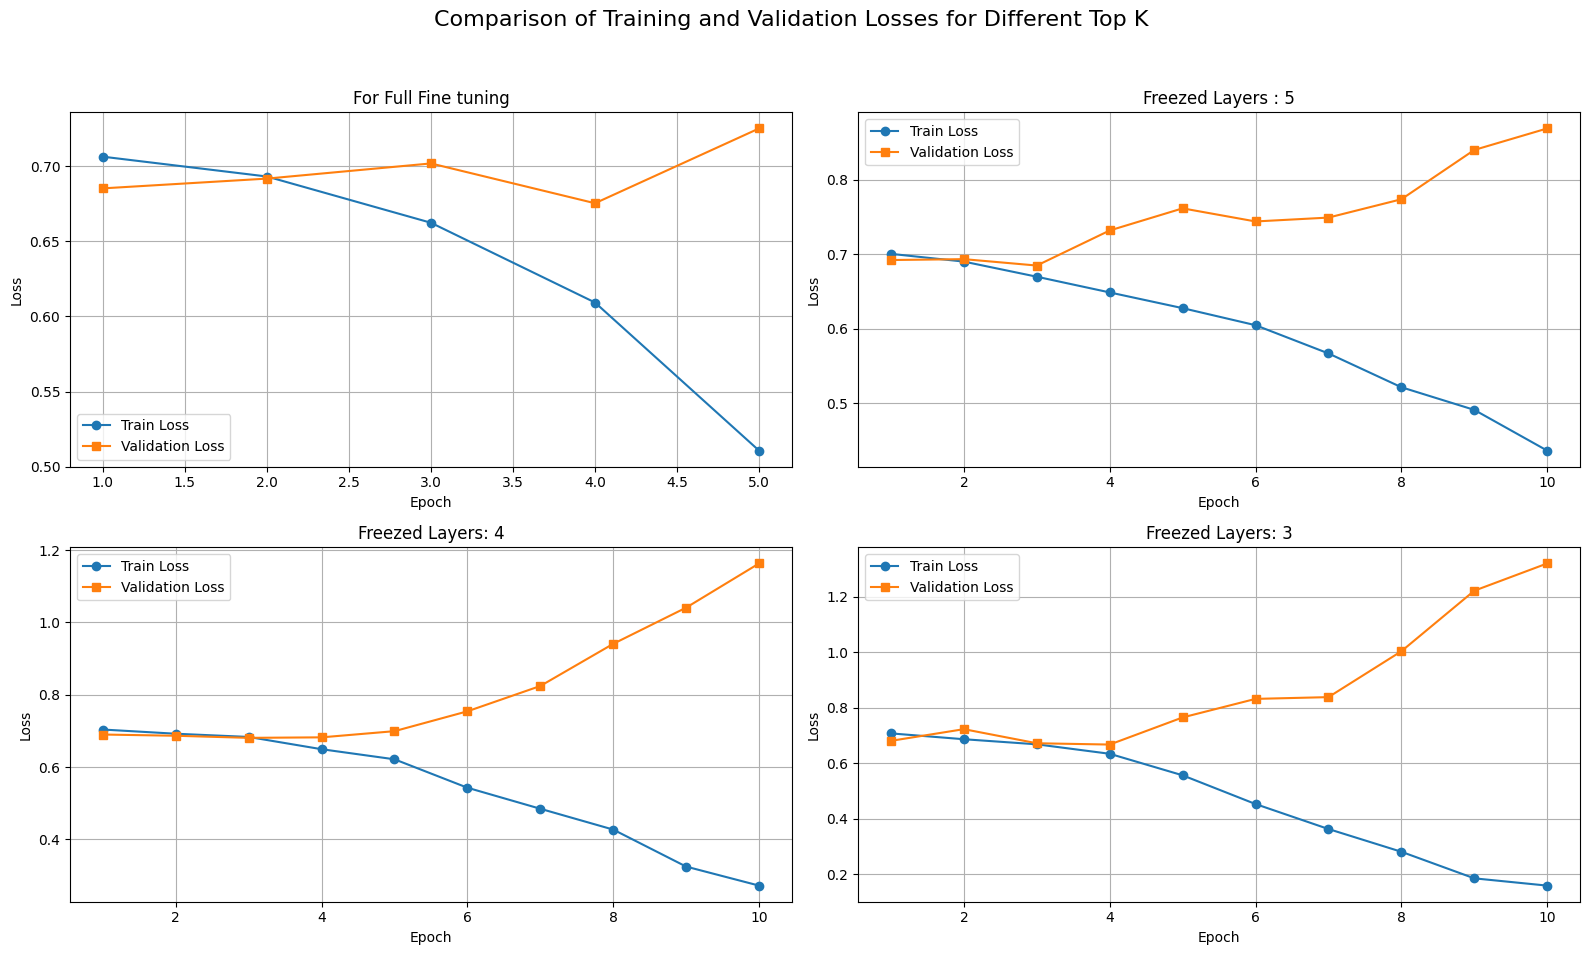

In [ ]:
import matplotlib.pyplot as plt

# Epochs
epochs_5 = [1, 2, 3, 4, 5]
epochs_10 = list(range(1, 11))

# Loss data for each setting
losses = {
    "For Full Fine tuning": {
        "epochs": epochs_5,
        "train_loss": [0.7064, 0.6932, 0.6624, 0.6093, 0.5107],
        "val_loss":   [0.6853, 0.6918, 0.7019, 0.6754, 0.7252]
    },
    "Freezed Layers : 5": {
        "epochs": epochs_10,
        "train_loss": [0.7004, 0.6900, 0.6697, 0.6486, 0.6275, 0.6046, 0.5667, 0.5213, 0.4909, 0.4362],
        "val_loss":   [0.6921, 0.6933, 0.6847, 0.7318, 0.7615, 0.7439, 0.7491, 0.7737, 0.8399, 0.8688]
    },
    "Freezed Layers: 4": {
        "epochs": epochs_10,
        "train_loss": [0.7037, 0.6921, 0.6832, 0.6493, 0.6214, 0.5428, 0.4846, 0.4270, 0.3247, 0.2721],
        "val_loss":   [0.6899, 0.6865, 0.6807, 0.6821, 0.6992, 0.7541, 0.8241, 0.9407, 1.0408, 1.1630]
    },
    "Freezed Layers: 3": {
        "epochs": epochs_10,
        "train_loss": [0.7073, 0.6863, 0.6680, 0.6339, 0.5564, 0.4530, 0.3631, 0.2812, 0.1856, 0.1594],
        "val_loss":   [0.6805, 0.7225, 0.6718, 0.6671, 0.7647, 0.8315, 0.8378, 1.0029, 1.2208, 1.3190]
    }
}

# Plotting
fig, axs = plt.subplots(2, 2, figsize=(16, 10))
axs = axs.flatten()

for i, (title, data) in enumerate(losses.items()):
    axs[i].plot(data["epochs"], data["train_loss"], label='Train Loss', marker='o')
    axs[i].plot(data["epochs"], data["val_loss"], label='Validation Loss', marker='s')
    axs[i].set_title(title)
    axs[i].set_xlabel("Epoch")
    axs[i].set_ylabel("Loss")
    axs[i].legend()
    axs[i].grid(True)

plt.suptitle("Comparison of Training and Validation Losses for Different Top K ", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


Use the **model with 3 frozen layers** (i.e., top layers fine-tuned) and load the checkpoint from Epoch 4.

It offers:

**Best validation loss overall (0.6671)**

Healthy train/val gap, indicating it's learned well without yet overfit

In [ ]:
from transformers import BertForSequenceClassification
from torch.optim import AdamW

# Load 6-layer LegalBERT
model = BertForSequenceClassification.from_pretrained("nlpaueb/legal-bert-small-uncased", num_labels=2)

# Freeze bottom 3 encoder layers: layers 0, 1, 2,
for layer_idx in range(3):
    for param in model.bert.encoder.layer[layer_idx].parameters():
        param.requires_grad = False

optimizer = AdamW(
    filter(lambda p: p.requires_grad, model.parameters()),
    lr=2e-6,  # or 2e-6 if you still want to be cautious
    weight_decay=0.01  # start here
)


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [ ]:
import torch
import time
import os

def multi_acc(y_pred, y_test):
    acc = (torch.log_softmax(y_pred, dim=1).argmax(dim=1) == y_test).sum().float() / float(y_test.size(0))
    return acc

CHECKPOINT_DIR = '/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal'

def train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5):
    os.makedirs(CHECKPOINT_DIR, exist_ok=True)

    # Resume training if requested
    if resume:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch3_wdecl_{start_epoch}.pt')
        if os.path.exists(checkpoint_path):
            print(f"Loading checkpoint from {checkpoint_path}...")
            checkpoint = torch.load(checkpoint_path, map_location=device)
            model.load_state_dict(checkpoint['model_state_dict'])
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            print(f"Checkpoint loaded. Resuming from epoch {start_epoch + 1}.")
        else:
            print(f"Checkpoint {checkpoint_path} not found. Starting fresh.")

    for epoch in range(start_epoch, total_epochs):
        start = time.time()
        model.train()
        total_train_loss = 0
        total_train_acc = 0

        for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(train_loader):
            optimizer.zero_grad()
            pair_token_ids = pair_token_ids.to(device)
            mask_ids = mask_ids.to(device)
            seg_ids = seg_ids.to(device)
            labels = y.to(device)

            loss, prediction = model(
                pair_token_ids,
                token_type_ids=seg_ids,
                attention_mask=mask_ids,
                labels=labels
            ).values()

            acc = multi_acc(prediction, labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            total_train_acc += acc.item()

        train_acc = total_train_acc / len(train_loader)
        train_loss = total_train_loss / len(train_loader)

        model.eval()
        total_val_acc = 0
        total_val_loss = 0

        with torch.no_grad():
            for batch_idx, (pair_token_ids, mask_ids, seg_ids, y) in enumerate(val_loader):
                pair_token_ids = pair_token_ids.to(device)
                mask_ids = mask_ids.to(device)
                seg_ids = seg_ids.to(device)
                labels = y.to(device)

                loss, prediction = model(
                    pair_token_ids,
                    token_type_ids=seg_ids,
                    attention_mask=mask_ids,
                    labels=labels
                ).values()

                acc = multi_acc(prediction, labels)

                total_val_loss += loss.item()
                total_val_acc += acc.item()

        val_acc = total_val_acc / len(val_loader)
        val_loss = total_val_loss / len(val_loader)

        end = time.time()
        hours, rem = divmod(end - start, 3600)
        minutes, seconds = divmod(rem, 60)

        print(f'Epoch {epoch+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
        print("{:0>2}:{:0>2}:{:05.2f}".format(int(hours), int(minutes), seconds))

        # Save checkpoint for this epoch
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f'checkpoint_epoch3_wdecl_{epoch+1}.pt')
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss
        }, checkpoint_path)
        print(f"Checkpoint saved for epoch {epoch+1} at {checkpoint_path}\n")


In [ ]:
#
train(model, train_loader, val_loader, optimizer, resume=False, start_epoch=0, total_epochs=5)


Epoch 1: train_loss: 0.7047 train_acc: 0.4958 | val_loss: 0.6921 val_acc: 0.4917
00:28:12.22
Checkpoint saved for epoch 1 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_wdecl_1.pt

Epoch 2: train_loss: 0.6981 train_acc: 0.5125 | val_loss: 0.6895 val_acc: 0.5375
00:27:55.20
Checkpoint saved for epoch 2 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_wdecl_2.pt

Epoch 3: train_loss: 0.6962 train_acc: 0.5188 | val_loss: 0.6923 val_acc: 0.5000
00:28:02.74
Checkpoint saved for epoch 3 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_wdecl_3.pt

Epoch 4: train_loss: 0.6936 train_acc: 0.5292 | val_loss: 0.6906 val_acc: 0.5542
00:29:22.20
Checkpoint saved for epoch 4 at /content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_wdecl_4.pt

Epoch 5: train_loss: 0.6923 train_acc: 0.5250 | val_loss: 0.6868 val_acc: 0.5417
00:27:52.40
Checkpoint saved for epoch 

# **Installing the BERT visualizer**

In [ ]:
pip install bertviz


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 110.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from transformers import BertTokenizer, BertModel
from bertviz import head_view
import torch

# Load model and tokenizer
model = BertModel.from_pretrained("nlpaueb/legal-bert-small-uncased", output_attentions=True)
tokenizer = BertTokenizer.from_pretrained("nlpaueb/legal-bert-small-uncased")

# Input sentence
sentence = "The tenant must pay the rent."

# Tokenize input
inputs = tokenizer.encode_plus(sentence, return_tensors='pt', return_attention_mask=True)

# Forward pass with attention
outputs = model(**inputs)
attention = outputs.attentions  # This is a tuple of attention tensors

# Convert input_ids back to token strings
token_ids = inputs['input_ids'][0]  # remove batch dim
tokens = tokenizer.convert_ids_to_tokens(token_ids)

# Now visualize
head_view(attention, tokens)


<IPython.core.display.Javascript object>

**For my trained model**

In [ ]:
from transformers import BertForSequenceClassification

model = BertForSequenceClassification.from_pretrained(
    "nlpaueb/legal-bert-small-uncased",
    num_labels=2,
    output_attentions=True,  # Required for BertViz
    attn_implementation="eager"  # Avoids future warnings
)

# Load checkpoint
checkpoint = torch.load("/content/drive/MyDrive/Colab Notebooks/GenAIproject/updatedfinal/checkpoint_epoch3_4.pt", map_location='cuda')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at nlpaueb/legal-bert-small-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 512, padding_idx=0)
      (position_embeddings): Embedding(512, 512)
      (token_type_embeddings): Embedding(2, 512)
      (LayerNorm): LayerNorm((512,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-5): 6 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=512, out_features=512, bias=True)
              (key): Linear(in_features=512, out_features=512, bias=True)
              (value): Linear(in_features=512, out_features=512, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=512, out_features=512, bias=True)
              (LayerNorm): LayerNorm((512,), eps=1e-12, e

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/GenAIproject/parsed_legal_qa_trainenglish.csv")

# Split into 80% train and 20% validation
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["label"])

# Reset index so we can safely access the first row
train_df = train_df.reset_index(drop=True)

# Extract first query and article
first_query = train_df.loc[0, "query"]
first_article = train_df.loc[0, "article"]

print("Query:", first_query)
print("Article:", first_article)


Query: If the branches of bamboo or trees on neighboring land cross the boundary line, the owner may cut off the branches himself, but may not make the owner of the bamboo or trees cut off the branches.
Article: Article 233: When the branches of bamboo or trees on neighboring land cross the boundary line, the owner of the bamboo or trees may be forced to cut off the branches.
2. If the roots of bamboo or trees on neighboring land cross the boundary line, the roots may be cut off.


In [ ]:
from transformers import AutoTokenizer
from bertviz import head_view
import torch

# Load tokenizer matching your model
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")  # or your model's tokenizer

# Prepare the input pair
text_pair = ( first_query,first_article)  # (context, hypothesis)
inputs = tokenizer.encode_plus(
    text_pair[0],
    text_pair[1],
    return_tensors='pt',
    return_attention_mask=True,
    add_special_tokens=True
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass with attentions
outputs = model.bert(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    output_attentions=True,
    return_dict=True
)

# Get tokens and attention
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
attention = outputs.attentions  # List of [batch, heads, seq_len, seq_len]

# Visualize with BertViz
head_view(attention, tokens)


In [ ]:
# Reset index so we can safely access the first row
val_df = val_df.reset_index(drop=True)

# Extract first query and article
first_query1 = val_df.loc[0, "query"]
first_article1 = val_df.loc[0, "article"]

print("Query:", first_query1)
print("Article:", first_article1)


Query: In a contract that involves the completion of work and the delivery of the object, the client must request repair of defects within one year from the delivery of the object.
Article: Article 637: In the case prescribed in the main text of the previous article, if the client does not notify the contractor of the non-conformity within one year from the time the client becomes aware of the non-conformity, the client cannot request completion of performance, request a reduction in remuneration, request damages, or terminate the contract on the grounds of the non-conformity.
2. The provisions of the preceding paragraph do not apply if the contractor knew of the non-conformity or was unaware of it due to gross negligence at the time the subject matter of the work is delivered to the client (or at the time the work is completed in cases where delivery is not required).


In [ ]:
from transformers import AutoTokenizer
from bertviz import head_view
import torch

# Load tokenizer matching your model
tokenizer = AutoTokenizer.from_pretrained("nlpaueb/legal-bert-base-uncased")  # or your model's tokenizer

# Prepare the input pair
text_pair = ( first_query1,first_article1)  # (context, hypothesis)
inputs = tokenizer.encode_plus(
    text_pair[0],
    text_pair[1],
    return_tensors='pt',
    return_attention_mask=True,
    add_special_tokens=True
)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Forward pass with attentions
outputs = model.bert(
    input_ids=inputs['input_ids'],
    attention_mask=inputs['attention_mask'],
    output_attentions=True,
    return_dict=True
)

# Get tokens and attention
tokens = tokenizer.convert_ids_to_tokens(inputs['input_ids'][0])
attention = outputs.attentions  # List of [batch, heads, seq_len, seq_len]

# Visualize with BertViz
head_view(attention, tokens)
